# Wine Challenge Fahim Garde.

In [0]:
from google.colab import drive
import pandas as pd
import pandas as pd
import numpy as np
from functools import reduce
from itertools import product
import os
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
mplstyle.use(['ggplot', 'fast'])
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_p='/content/drive/My Drive'
def read(red_p,white_p):
    return pd.read_csv(red_p,sep=";"),pd.read_csv(white_p,sep=";")
red,white=read(os.path.join(drive_p,"winequality-red.csv"),os.path.join(drive_p,"winequality-white.csv"))

## First observations

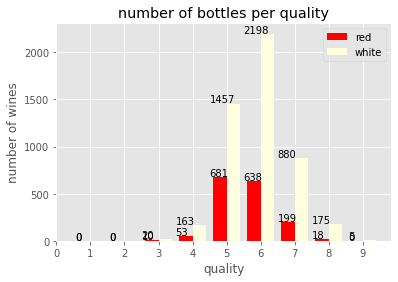

In [0]:
g="quality"
ns,bins,_=plt.hist([red[g],white[g]],bins=[i+0.5 for i in range(10)],label=(["red","white"]),color=("red","lightyellow"))
plt.title("number of bottles per quality")
plt.xlabel("quality")
plt.xticks([i for i in range(10)])
plt.ylabel("number of wines")
for n in ns:
    for i,b in zip(n,bins):
        plt.text(b,i+10,"{:2.0f}".format(i))
plt.legend()
plt.show()

* The distribution of quality is different between the red and the white wines. Therefore the model should be parametrized on `white` or `black`.
* Most wines are awarded 5 or 6, then a few 7.



## A probabilistic model

We define the output set as $O=\{good,bad\}$.`quality` is interpreted as a log-odd distribution for $good$ (centered around 5), defining the following property:
$$P(good)=sigmoid(quality-5)$$


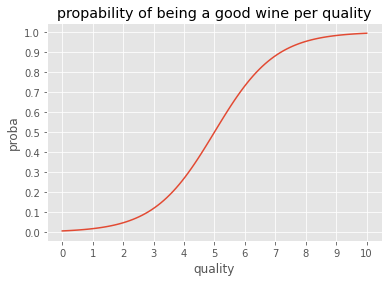

In [0]:
u=np.linspace(0,10,100)-5
plt.plot(u+5,1/(1+np.exp(-u)))
plt.yticks([i*10**(-1) for i in range(11)])
plt.xticks([i for i in range(0,11)])
plt.title("propability of being a good wine per quality")
plt.xlabel("quality")
plt.ylabel("proba")
plt.show()

We define the task as a binary classification over the set $O=\{good,bad\}$. We use the cross-entropy loss function, minimizing the KL divergence with respect the probability defined above.

As in logistic regression, the classification task can be first seen as a regression on the logg-odd ($L=quality-5$), then using $$ \left\{ \begin{array}{l}  L \lt 0 \rightarrow bad \\ L>0 \rightarrow good \end{array}\right.$$
Sadly, it is currently not possible to perform logistic regression directly using sklearn.
Therefore, the following approach will be focused on a regression over `quality`.

---


The tuples $t \in red\cup white$  define the training set. Tuples from the two datasets are grouped to benefit from a larger training set. To ensure that the model is able to behave differently depending the type (`red`or `white`) we grouped by concatenating the two tuples. $$t_{new}=[t_{red},t_{white}]$$
This behavior is wanted because of the distribution discrepancy between `red`and `white` quality.



In [0]:
whn=lambda s: s if s=="quality" else "w-"+s
rdn=lambda s: s if s=="quality" else "r-"+s
red=red.rename(rdn,axis='columns',)
white=white.rename(whn,axis='columns',)
full=pd.concat([red,white],join='outer').fillna(0)
y=full["quality"]
X=full.drop(["quality"],axis=1)

In [0]:
import tensorflow as tf
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import classification_report
sig=lambda x:1/(1+np.exp(-x))
y=sig(y-5)
#y=y>5
X,Xh,y,yh=split(X,y) #h for holdout

In [0]:
y

717     False
3114     True
2766     True
3115     True
2975     True
        ...  
235      True
130     False
1613     True
3400     True
1552     True
Name: quality, Length: 4872, dtype: bool

In [0]:
input_shape=X.shape[1]

def KLD_c(y_true,y_pred):
  return tf.keras.losses.KLD(y_true,y_pred) + tf.keras.losses.KLD(1-y_true,1-y_pred)

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(input_shape)),
  tf.keras.layers.Dense(input_shape, activation='relu'),
  tf.keras.layers.Dense(input_shape, activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss=KLD_c,
              metrics=[tf.keras.metrics.BinaryCrossentropy(from_logits=False)]
              )
# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 300
history = model.fit(
  X, y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  binary_crossentropy  val_loss  val_binary_crossentropy  epoch
41  0.549527             0.549598  0.531933                 0.531543     41
42  0.541437             0.541492  0.539468                 0.540811     42
43  0.538489             0.538385  0.524605                 0.524570     43
44  0.535940             0.535740  0.546980                 0.544378     44
45  0.543889             0.544134  0.580105                 0.584942     45

In [0]:
loss = model.evaluate(Xh, yh, verbose=2)



51/51 - 0s - loss: 0.4974 - binary_crossentropy: 0.4982


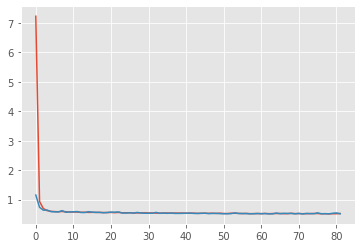

In [0]:
plt.plot((hist["loss"]))
plt.plot((hist["val_loss"]))

In [0]:
yp = model.predict(X).flatten()
yp

array([0.7209015 , 0.93528306, 0.9717758 , ..., 0.86527693, 0.3882844 ,
       0.9516568 ], dtype=float32)

In [0]:
posp=yp>0.5
negp=yp<=0.5
pos=y>0.5
neg=y<=0.5
tp=sum(pos&posp)
print(tp/len(y))